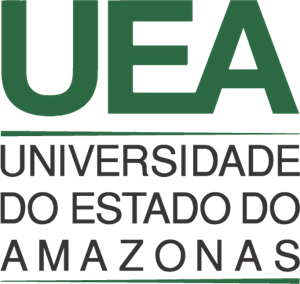

- Módulo: Machine Learning Aplicado I

- Equipe: [NAME]

- Alunos:
  
  - Andrew da Silva Santos
  - Eberth Felipe Castro da Cruz
  - Eduardo Amorim de Araújo




#Coding

##General Imports

In [62]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings

# Scikit-learn
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
# from kaggle.api.kaggle_api_extended import KaggleApi
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.neighbors import KNeighborsClassifier, DistanceMetric
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, SCORERS

# Configs
pd.options.display.max_columns = None
warnings.filterwarnings('ignore')

Install Shap

In [2]:
!pip install shap

     |████████████████████████████████| 356 kB 6.8 MB/s 
  Created wheel for shap: filename=shap-0.39.0-cp37-cp37m-linux_x86_64.whl size=491635 sha256=51bba816233b6e651a715ceac255a67af8905fd4d3c3189af916c7661ad716d6
  Stored in directory: /root/.cache/pip/wheels/ca/25/8f/6ae5df62c32651cd719e972e738a8aaa4a87414c4d2b14c9c0
Successfully built shap


##Get data from Kaggle API
Reference: https://colab.research.google.com/github/corrieann/kaggle/blob/master/kaggle_api_in_colab.ipynb

###Install Kaggle and Import API

In [4]:
!pip install kaggle

###Get Files

In [5]:
# Kaggle API reference: https://github.com/Kaggle/kaggle-api
def import_kaggle_api_key():
  from google.colab import files

  uploaded = files.upload()

  for fn in uploaded.keys():
    print('User uploaded file "{name}" with length {length} bytes'.format(
        name=fn, length=len(uploaded[fn])))
    
  # Then move kaggle.json into the folder where the API expects to find it.
  !mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json
  from kaggle.api.kaggle_api_extended import KaggleApi

def get_data_from_competition():
  # Kaggle competition link
  # https://www.kaggle.com/c/aml-t2-fw/data
  !kaggle competitions download -c aml-t2-fw
  !ls -la ./
  !unzip ./Dados_Teste.csv.zip
  !unzip ./Dados_Treino.csv.zip
  !ls -la ./

Run this function to import your API.

In order to get you key, got to **Kaggle** > Account > Create New API Token

Import `kaggle.json` file

In [6]:
import_kaggle_api_key()

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 68 bytes


In [7]:
get_data_from_competition()

# download em ambiente local
# !kaggle competitions download -c aml-t2-fw
# !unzip ./aml-t2-fw.zip


  0% 0.00/2.30M [00:00<?, ?B/s]
100% 2.30M/2.30M [00:00<00:00, 77.1MB/s]
 25% 5.00M/20.3M [00:00<00:00, 41.3MB/s]
100% 20.3M/20.3M [00:00<00:00, 99.0MB/s]
  0% 0.00/114k [00:00<?, ?B/s]
100% 114k/114k [00:00<00:00, 104MB/s]
  0% 0.00/28.2k [00:00<?, ?B/s]
100% 28.2k/28.2k [00:00<00:00, 27.4MB/s]
total 23268
drwxr-xr-x 1 root root     4096 Jul 24 17:41 .
drwxr-xr-x 1 root root     4096 Jul 24 17:37 ..
drwxr-xr-x 4 root root     4096 Jul 16 13:19 .config
-rw-r--r-- 1 root root  2410135 Jul 24 17:41 Dados_Teste.csv.zip
-rw-r--r-- 1 root root 21243109 Jul 24 17:41 Dados_Treino.csv.zip
-rw-r--r-- 1 root root    28910 Jul 24 17:41 Dicionario_de_Dados.csv
drwxr-xr-x 1 root root     4096 Jul 16 13:20 sample_data
-rw-r--r-- 1 root root   117176 Jul 24 17:41 Template_Submissao.csv
Archive:  ./Dados_Teste.csv.zip
  inflating: Dados_Teste.csv         
Archive:  ./Dados_Treino.csv.zip
  inflating: Dados_Treino.csv        
total 108712
drwxr-xr-x 1 root root     4096 Jul 24 17:41 .
drwxr-xr-x 1 root

##Datasets


###Initial view

In [81]:
df_dados_teste = pd.read_csv('./Dados_Teste.csv')
df_dados_treino = pd.read_csv('./Dados_Treino.csv')
df_dict_dados = pd.read_csv('./Dicionario_de_Dados.csv')
df_template_sub = pd.read_csv('./Template_Submissao.csv')

In [9]:
def explore_dataset(df_aux):
  delimiter = '--------------------'
  print(df_aux.shape)
  print(delimiter)
  print(round(df_aux.describe(), 2))
  print(delimiter)
  df_aux.info(verbose=True)

Dados de Treino

In [17]:
df_dados_treino.head()

,encounter_id,hospital_id,age,bmi,elective_surgery,ethnicity,gender,height,icu_id,pre_icu_los_days,readmission_status,weight,albumin_apache,apache_post_operative,arf_apache,bilirubin_apache,bun_apache,creatinine_apache,fio2_apache,gcs_eyes_apache,gcs_motor_apache,gcs_unable_apache,gcs_verbal_apache,glucose_apache,heart_rate_apache,hematocrit_apache,intubated_apache,map_apache,paco2_apache,paco2_for_ph_apache,pao2_apache,ph_apache,resprate_apache,sodium_apache,temp_apache,urineoutput_apache,ventilated_apache,wbc_apache,d1_diasbp_invasive_max,d1_diasbp_invasive_min,d1_diasbp_max,d1_diasbp_min,d1_diasbp_noninvasive_max,d1_diasbp_noninvasive_min,d1_heartrate_max,d1_heartrate_min,d1_mbp_invasive_max,d1_mbp_invasive_min,d1_mbp_max,d1_mbp_min,d1_mbp_noninvasive_max,d1_mbp_noninvasive_min,d1_resprate_max,d1_resprate_min,d1_spo2_max,d1_spo2_min,d1_sysbp_invasive_max,d1_sysbp_invasive_min,d1_sysbp_max,d1_sysbp_min,d1_sysbp_noninvasive_max,d1_sysbp_noninvasive_min,d1_temp_max,d1_temp_min,h1_diasbp_invasive_max,h1_diasbp_invasive_min,h1_diasbp_max,h1_diasbp_min,h1_diasbp_noninvasive_max,h1_diasbp_noninvasive_min,h1_heartrate_max,h1_heartrate_min,h1_mbp_invasive_max,h1_mbp_invasive_min,h1_mbp_max,h1_mbp_min,h1_mbp_noninvasive_max,h1_mbp_noninvasive_min,h1_resprate_max,h1_resprate_min,h1_spo2_max,h1_spo2_min,h1_sysbp_invasive_max,h1_sysbp_invasive_min,h1_sysbp_max,h1_sysbp_min,h1_sysbp_noninvasive_max,h1_sysbp_noninvasive_min,h1_temp_max,h1_temp_min,d1_albumin_max,d1_albumin_min,d1_bilirubin_max,d1_bilirubin_min,d1_bun_max,d1_bun_min,d1_calcium_max,d1_calcium_min,d1_creatinine_max,d1_creatinine_min,d1_glucose_max,d1_glucose_min,d1_hco3_max,d1_hco3_min,d1_hemaglobin_max,d1_hemaglobin_min,d1_hematocrit_max,d1_hematocrit_min,d1_inr_max,d1_inr_min,d1_lactate_max,d1_lactate_min,d1_platelets_max,d1_platelets_min,d1_potassium_max,d1_potassium_min,d1_sodium_max,d1_sodium_min,d1_wbc_max,d1_wbc_min,h1_albumin_max,h1_albumin_min,h1_bilirubin_max,h1_bilirubin_min,h1_bun_max,h1_bun_min,h1_calcium_max,h1_calcium_min,h1_creatinine_max,h1_creatinine_min,h1_glucose_max,h1_glucose_min,h1_hco3_max,h1_hco3_min,h1_hemaglobin_max,h1_hemaglobin_min,h1_hematocrit_max,h1_hematocrit_min,h1_inr_max,h1_inr_min,h1_lactate_max,h1_lactate_min,h1_platelets_max,h1_platelets_min,h1_potassium_max,h1_potassium_min,h1_sodium_max,h1_sodium_min,h1_wbc_max,h1_wbc_min,d1_arterial_pco2_max,d1_arterial_pco2_min,d1_arterial_ph_max,d1_arterial_ph_min,d1_arterial_po2_max,d1_arterial_po2_min,d1_pao2fio2ratio_max,d1_pao2fio2ratio_min,h1_arterial_pco2_max,h1_arterial_pco2_min,h1_arterial_ph_max,h1_arterial_ph_min,h1_arterial_po2_max,h1_arterial_po2_min,h1_pao2fio2ratio_max,h1_pao2fio2ratio_min,aids,cirrhosis,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis,diabetes_mellitus
0,214826,118,68.0,22.732803,0,2,1,180.3,92,0.541667,0,73.9,2.3,0,0,0.4,31.0,2.51,0.0,3.0,6.0,0.0,4.0,168.0,118.0,27.4,0,40.0,0.0,0.0,0.0,0.00,36.0,134.0,39.3,0.0,0,14.1,46.0,32.0,68.0,37.0,68.0,37.0,119.0,72.0,66.0,40.0,89.0,46.0,89.0,46.0,34.0,10.0,100.0,74.0,122.0,64.0,131.0,73.0,131.0,73.0,39.9,37.2,0.0,0.0,68.0,63.0,68.0,63.0,119.0,108.0,0.0,0.0,86.0,85.0,86.0,85.0,26.0,18.0,100.0,74.0,0.0,0.0,131.0,115.0,131.0,115.0,39.5,37.5,2.3,2.3,0.4,0.4,31.0,30.0,8.5,7.4,2.51,2.23,168.0,109.0,19.0,15.0,8.9,8.9,27.4,27.4,0.0,0.0,1.3,1.0,233.0,233.0,4.0,3.4,136.0,134.0,14.1,14.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.000000,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,1
1,246060,81,77.0,27.421875,0,2,0,160.0,90,0.927778,0,70.2,0.0,0,0,0.0,9.0,0.56,1.0,1.0,3.0,0.0,1.0,145.0,120.0,36.9,0,46.0,37.0,37.0,51.0,7.45,33.0,145.0,35.1,0.0,1,12.7,0.0,0.0,95.0,31.0,95.0,31.0,118.0,72.0,0.0,0.0,120.0,38.0,120.0,38.0,32.0,12.0,100.0,70.0,0.0,0.0,159.0,67.0,159.0,67.0,36.3,35.1,0.0,0.0,61.0,48.0,61.0,48.0,114.0,100.0,0.0,0.0,85.0,57.0,85.0,57.0,31.0,28.0,95.0,70.0,0.0,0.0,95.0,71.0,95.0,71.0,36.

In [18]:
explore_dataset(df_dados_treino)

(117141, 174)
--------------------
       encounter_id  hospital_id        age        bmi  elective_surgery  \
count     117141.00    117141.00  117141.00  117141.00         117141.00   
mean      213013.98       106.22      59.63      28.12              0.19   
std        38128.78        63.48      20.35       9.72              0.39   
min       147001.00         1.00       0.00       0.00              0.00   
25%       179951.00        50.00      50.00      23.11              0.00   
50%       213051.00       112.00      63.00      27.34              0.00   
75%       246063.00       165.00      75.00      32.56              0.00   
max       279000.00       204.00      89.00      67.81              1.00   

       ethnicity     gender     height     icu_id  pre_icu_los_days  \
count  117141.00  117141.00  117141.00  117141.00         117141.00   
mean        2.02       0.54     166.92     662.94              0.84   
std         1.07       0.50      23.75     304.33              2.50

Dados de Teste

In [ ]:
df_dados_teste.head()

,encounter_id,hospital_id,age,bmi,elective_surgery,ethnicity,gender,height,hospital_admit_source,icu_admit_source,...,h1_arterial_po2_min,h1_pao2fio2ratio_max,h1_pao2fio2ratio_min,aids,cirrhosis,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis
0,231640,42,35.0,29.060607,0,Caucasian,F,169.0,Emergency Department,Accident & Emergency,...,NaN,NaN,NaN,0,0,0,0,0,0,0
1,220057,100,84.0,23.128938,0,Caucasian,F,170.2,Emergency Department,Accident & Emergency,...,NaN,NaN,NaN,0,0,0,0,0,0,0
2,238466,128,61.0,42.873376,0,Caucasian,M,175.2,Emergency Department,Accident & Emergency,...,NaN,NaN,NaN,0,0,0,0,0,0,0
3,214794,77,86.0,25.795461,0,Caucasian,F,162.6,NaN,Floor,...,NaN,NaN,NaN,0,0,0,0,0,0,0
4,255804,110,38.0,41.868512,1,African American,F,170.0,Operating Room,Operating Room / Recovery,...,202.0,202.0,202.0,0,0,0,0,0,0,0


In [ ]:
explore_dataset(df_dados_teste)

(13016, 179)
--------------------
       encounter_id  hospital_id       age       bmi  elective_surgery  \
count      13016.00     13016.00  12516.00  12561.00          13016.00   
mean      212882.75       105.04     61.87     29.02              0.19   
std        37940.12        63.46     16.80      8.09              0.39   
min       147000.00         1.00      0.00     14.84              0.00   
25%       180537.25        47.00     52.00     23.61              0.00   
50%       212676.50       110.00     64.00     27.55              0.00   
75%       245433.25       163.00     75.00     32.61              0.00   
max       278994.00       204.00     89.00     67.81              1.00   

         height    icu_id  pre_icu_los_days  readmission_status    weight  \
count  12794.00  13016.00          13016.00             13016.0  12673.00   
mean     169.64    657.86              0.82                 0.0     83.66   
std       10.81    303.61              2.31                 0.0     

###ETL

Pré-processamento de dados de treino e teste

In [11]:
#Transform fields from Object to int
def transform_fields(df, fields):
  label_encoder = LabelEncoder()
  for field in fields:
    df[field] = label_encoder.fit_transform(list(df[field].values))
  return df

#Treat numeric values from dataframe
def str_to_num(df_aux, index):
  for i in index:
    col_name = df_aux.columns[i]
    # df_aux[col_name] = df_aux[col_name].str.replace('.', '')
    # df_aux[col_name] = df_aux[col_name].str.replace(',', '.')
    df_aux[col_name] = pd.to_numeric(df_aux[col_name])
  return df_aux

In [82]:
fields_to_tranform = ['ethnicity', 'gender']
df_dados_teste = transform_fields(df_dados_teste, fields_to_tranform)
df_dados_treino = transform_fields(df_dados_treino, fields_to_tranform)

# Change field type
df_dados_teste = str_to_num(df_dados_teste, [3])
df_dados_treino = str_to_num(df_dados_treino, [3])

In [83]:
#Remove columns
rm_columns = ['hospital_admit_source', 'icu_admit_source', 
              'icu_stay_type', 'icu_type', 'apache_2_diagnosis', 
              'apache_3j_diagnosis', 'height']

df_dados_teste.drop(columns=rm_columns, inplace=True)
df_dados_treino.drop(columns=rm_columns, inplace=True)

In [84]:
#Replace NaN values with 0
df_dados_teste = df_dados_teste.fillna(0)
df_dados_treino = df_dados_treino.fillna(0)

In [85]:
#Check NaN values
print(np.any(np.isnan(df_dados_teste)))
print(np.any(np.isnan(df_dados_treino)))

False
False


##Machine Learning Algorithms

Algoritmos utilizados para prever a presença de Diabetes em pacientes

### Utility Functions to help the process

In [47]:
def print_model_result(model, X_tr, X_ts, y_tr, y_ts):
  print(f'Acurácia (Treino): {round(accuracy_score(y_tr, model.predict(X_tr)), 2)}')
  print(f'Acurácia (Teste): {round(accuracy_score(y_ts, model.predict(X_ts)), 2)}')
  print(classification_report(y_ts, model.predict(X_ts), target_names=['NO', 'YES']))
  plot_confusion_matrix(model, X_ts, y_ts)

def plot_confusion_matrix(model, X_ts, y_ts):
  fig, ax = plt.subplots(figsize=(10,8))
  cm = confusion_matrix(y_ts, model.predict(X_ts), labels=model.classes_)
  disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                display_labels=pd.Series(model.classes_).map({0: 'No', 1: 'Yes'}))
  disp.plot(cmap=plt.cm.Blues, ax=ax)
  plt.show()

def get_samples_for_train_test(X, y, div_size, random):
  X_tr, X_ts, y_tr, y_ts = train_test_split(X, 
                                            y,
                                            stratify = y,
                                            test_size=div_size, 
                                            random_state=random)
  print('Amostras de treino:')
  print(f' * X_train: {X_tr.shape}')
  print(f' * y_train: {y_tr.shape}')

  print('Amostras de teste:')
  print(f' * X_test: {X_ts.shape}')
  print(f' * y_test: {y_ts.shape}')
  return X_tr, X_ts, y_tr, y_ts

def create_knn_model(neighbors, X_tr, X_ts, y_tr, y_ts):
  model = KNeighborsClassifier(n_neighbors=neighbors)
  model.fit(X_tr, y_tr)
  print_model_result(model, X_tr, X_ts, y_tr, y_ts)
  return model

def create_tree_model(depth, X_tr, X_ts, y_tr, y_ts):
  tree_model = DecisionTreeClassifier(criterion='entropy',
                                    max_depth=depth,
                                    min_samples_split=2,
                                    random_state=0)

  tree_model.fit(X_tr, y_tr)
  print_model_result(tree_model, X_tr, X_ts, y_tr, y_ts)
  return tree_model

def create_logistic_model(X_tr, X_ts, y_tr, y_ts):
  logistic_model = LogisticRegression()
  logistic_model.fit(X_tr, y_tr)
  print_model_result(logistic_model, X_tr, X_ts, y_tr, y_ts)
  return logistic_model

In [38]:
def upload_submit(path, msg):
  !kaggle competitions submit -c aml-t2-fw -f '{path}' -m f"Descrição: {msg}"

def send_submit(df, msg):
  now = datetime.now()
  timestamp = datetime.timestamp(now)
  df.to_csv(f'submit_{timestamp}.csv', index=False)
  upload_submit(f'submit_{timestamp}.csv', msg)


def update_df_template(df, df_result_test):
  df['diabetes_mellitus'] = df_result_test.loc[df_result_test['encounter_id'] == df['encounter_id']]['predict']
  return df

def get_dataframe_for_submission(model):
  df_result = df_dados_teste.copy()
  df_result_template = df_template_sub.copy()
  df_result['predict'] = model.predict_proba(df_result)[:,1]
  df_result_template = df_result_template.apply(lambda x: update_df_template(x, df_result), axis=1)
  df_result_template = df_result_template.astype({'encounter_id': 'int64'})
  return df_result_template

def view_result(df_result_view):
  df_result_view = round(df_result_view, 2)
  plt.figure(figsize = (16,10))
  ax = sns.countplot(x = 'diabetes_mellitus', 
                    data = df_result_view)

  ax.set_title('Previsão de Pacientes Diabéticos')
  ax.set_xlabel('Diabético')
  ax.set_ylabel('Qtd. de pacientes')
  plt.xticks(rotation=45)
  plt.show()

In [21]:
now = datetime.now()
timestamp = datetime.timestamp(now)
print(f"submit_{timestamp}.csv")
  

submit_1627148897.159968.csv


### Treinamento dos Modelos

In [87]:
# Get data for X and y

# tentativa de normalização
# scaler = MinMaxScaler()

# X = df_dados_treino.loc[:,'encounter_id':'solid_tumor_with_metastasis']

# X[X.columns.values] = scaler.fit_transform(X[X.columns.values])

# X = X.to_numpy()

X = df_dados_treino.loc[:,'encounter_id':'solid_tumor_with_metastasis'].to_numpy()

y = df_dados_treino['diabetes_mellitus'].to_numpy()

In [ ]:
print(X)

[[2.14826e+05 1.18000e+02 6.80000e+01 ... 0.00000e+00 0.00000e+00
  0.00000e+00]
 [2.46060e+05 8.10000e+01 7.70000e+01 ... 0.00000e+00 0.00000e+00
  0.00000e+00]
 [2.62220e+05 1.18000e+02 8.10000e+01 ... 0.00000e+00 0.00000e+00
  0.00000e+00]
 ...
 [2.19719e+05 7.00000e+00 7.30000e+01 ... 0.00000e+00 0.00000e+00
  0.00000e+00]
 [2.22562e+05 1.70000e+02 8.10000e+01 ... 0.00000e+00 0.00000e+00
  0.00000e+00]
 [1.57942e+05 7.00000e+00 3.50000e+01 ... 0.00000e+00 0.00000e+00
  0.00000e+00]]


In [135]:
X_train, X_test, y_train, y_test = get_samples_for_train_test(X, y, div_size=0.25, random=0)

Amostras de treino:
 * X_train: (87855, 172)
 * y_train: (87855,)
Amostras de teste:
 * X_test: (29286, 172)
 * y_test: (29286,)


#### KNN - k vizinhos mais próximos
Treino do Modelo utilizando a algoritmo KNN

****************** KNN ******************
Acurácia (Treino): 0.79
Acurácia (Teste): 0.79
              precision    recall  f1-score   support

          NO       0.79      1.00      0.88     22952
         YES       0.59      0.03      0.05      6334

    accuracy                           0.79     29286
   macro avg       0.69      0.51      0.46     29286
weighted avg       0.74      0.79      0.70     29286



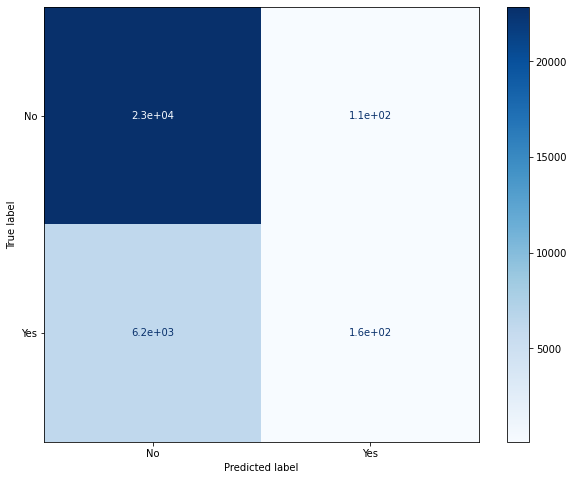

In [36]:
print('****************** KNN ******************')

knn_model = create_knn_model(neighbors=20, X_tr=X_train, X_ts=X_test, y_tr=y_train, y_ts=y_test)

In [26]:
result_knn = get_dataframe_for_submission(knn_model)
result_knn.head()

,encounter_id,diabetes_mellitus
0,231640,0.30
1,220057,0.35
2,238466,0.15
3,214794,0.50
4,255804,0.05


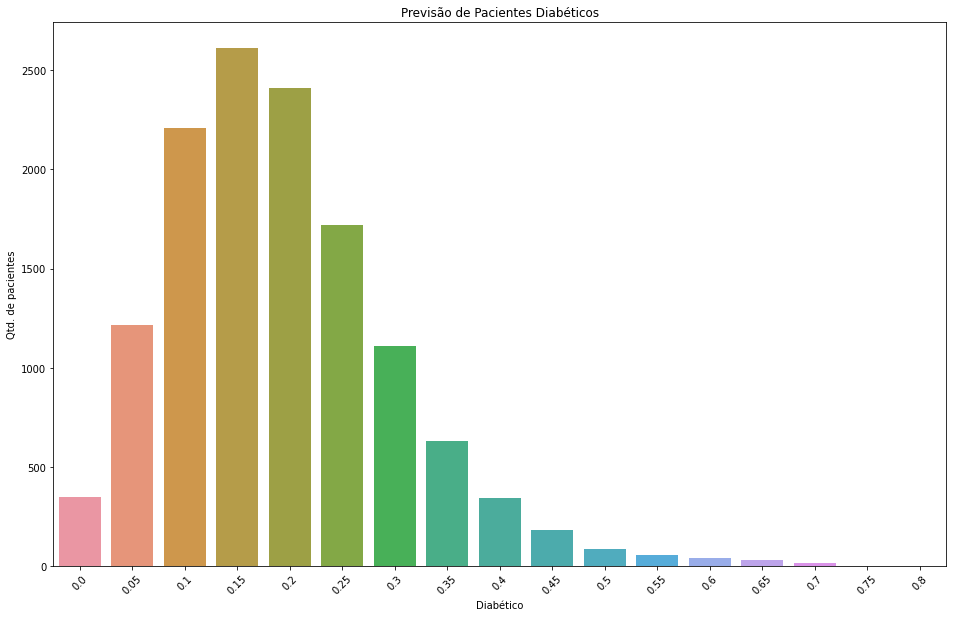

In [29]:
view_result(result_knn)

In [ ]:
# envia para o kagle o df com o resultado gerado
send_submit(result_knn, 'Teste 4 knn')

100% 146k/146k [00:01<00:00, 114kB/s]
Successfully submitted to Machine Learning Aplicado I - Trabalho Final

#### Decision Tree
Treino do Modelo utilizando a algoritmo Árvore de decisão

****************** ARVORE ******************
Acurácia (Treino): 0.81
Acurácia (Teste): 0.81
              precision    recall  f1-score   support

          NO       0.85      0.92      0.88     22952
         YES       0.59      0.41      0.48      6334

    accuracy                           0.81     29286
   macro avg       0.72      0.66      0.68     29286
weighted avg       0.79      0.81      0.80     29286



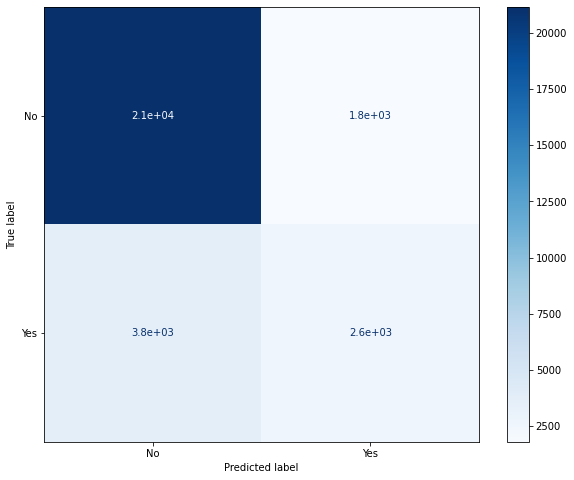

In [141]:
print('****************** ARVORE ******************')

tree_model = create_tree_model(depth=5, X_tr=X_train, X_ts=X_test, y_tr=y_train, y_ts=y_test)

In [137]:
# gera o df para submissão com base no template
result_tree = get_dataframe_for_submission(tree_model)
result_tree.head()

,encounter_id,diabetes_mellitus
0,231640,0.002982
1,220057,0.650492
2,238466,0.419038
3,214794,0.212607
4,255804,0.341365


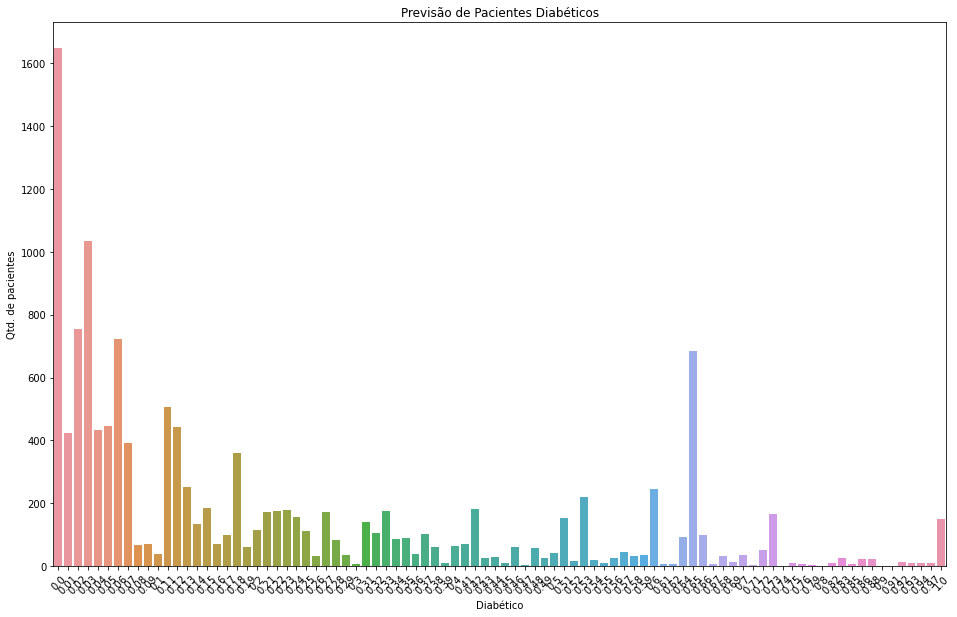

In [142]:
view_result(result_tree)

In [139]:
# envia para o kagle o df com o resultado gerado
send_submit(result_tree, 'Teste 4 decision tree')

100% 314k/314k [00:01<00:00, 226kB/s]
Successfully submitted to Machine Learning Aplicado I - Trabalho Final

#### Logistic Regression
Treino do Modelo utilizando a algoritmo de Regressão Logística

****************** Regressão Logística ******************
Acurácia (Treino): 0.8
Acurácia (Teste): 0.8
              precision    recall  f1-score   support

          NO       0.82      0.96      0.88     22952
         YES       0.60      0.24      0.34      6334

    accuracy                           0.80     29286
   macro avg       0.71      0.60      0.61     29286
weighted avg       0.77      0.80      0.76     29286



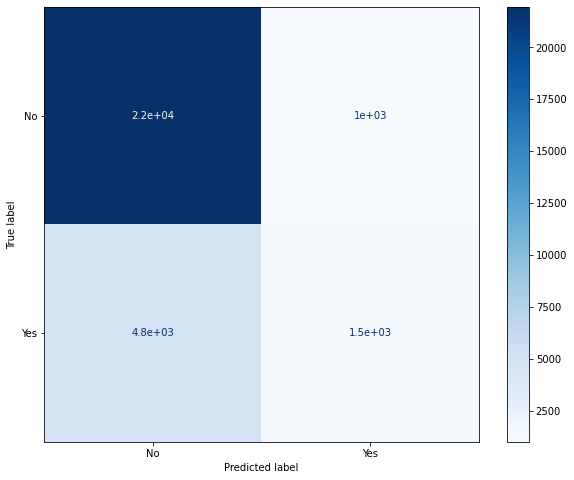

In [143]:
print('****************** Regressão Logística ******************')

logistic_model = create_logistic_model(X_tr=X_train, X_ts=X_test, y_tr=y_train, y_ts=y_test)

In [144]:
# gera o df para submissão com base no template
result_logistic = get_dataframe_for_submission(logistic_model)
result_logistic.head()

,encounter_id,diabetes_mellitus
0,231640,0.117119
1,220057,0.347681
2,238466,0.243951
3,214794,0.212427
4,255804,0.230555


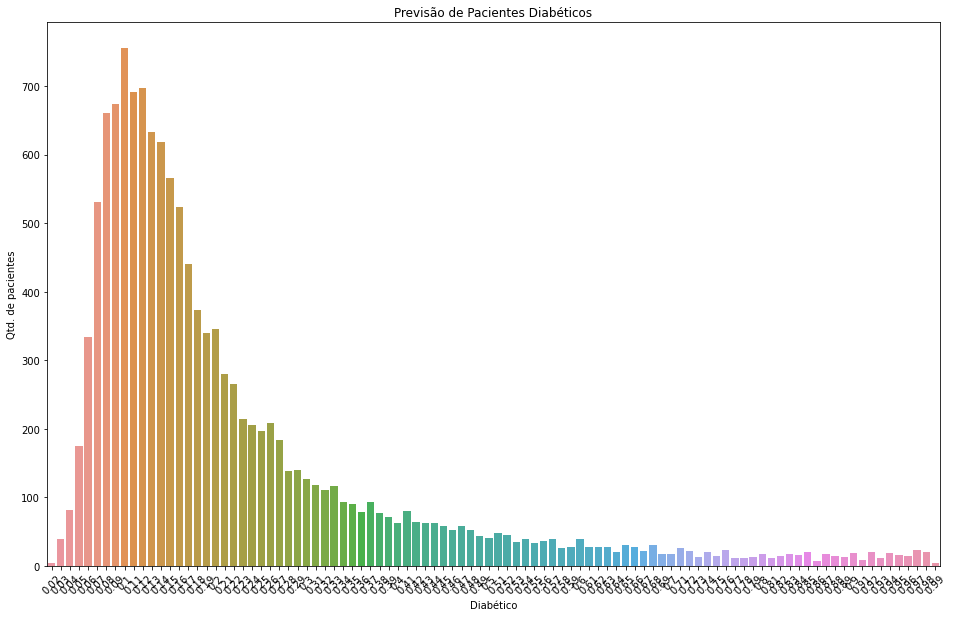

In [145]:
view_result(result_logistic)

In [45]:
# envia para o kagle o df com o resultado gerado
send_submit(result_logistic, 'Teste 1 logistic regression')

100% 339k/339k [00:00<00:00, 425kB/s]
Successfully submitted to Machine Learning Aplicado I - Trabalho Final

### Ensemble Learning

Possible metrics to choose

In [146]:
SCORERS.keys()

dict_keys(['explained_variance', 'r2', 'max_error', 'neg_median_absolute_error', 'neg_mean_absolute_error', 'neg_mean_squared_error', 'neg_mean_squared_log_error', 'neg_root_mean_squared_error', 'neg_mean_poisson_deviance', 'neg_mean_gamma_deviance', 'accuracy', 'roc_auc', 'roc_auc_ovr', 'roc_auc_ovo', 'roc_auc_ovr_weighted', 'roc_auc_ovo_weighted', 'balanced_accuracy', 'average_precision', 'neg_log_loss', 'neg_brier_score', 'adjusted_rand_score', 'homogeneity_score', 'completeness_score', 'v_measure_score', 'mutual_info_score', 'adjusted_mutual_info_score', 'normalized_mutual_info_score', 'fowlkes_mallows_score', 'precision', 'precision_macro', 'precision_micro', 'precision_samples', 'precision_weighted', 'recall', 'recall_macro', 'recall_micro', 'recall_samples', 'recall_weighted', 'f1', 'f1_macro', 'f1_micro', 'f1_samples', 'f1_weighted', 'jaccard', 'jaccard_macro', 'jaccard_micro', 'jaccard_samples', 'jaccard_weighted'])

In [148]:
#@title Choose metric
work_metric = "roc_auc" #@param ["roc_auc", "accuracy"]

Functions to help Ensemble process

In [149]:
def create_ens_logistic_model():
  model = LogisticRegression()
  return model

def create_ens_decision_tree(depth):
  model = DecisionTreeClassifier(criterion='entropy',
                                    max_depth=depth,
                                    min_samples_split=2,
                                    random_state=0)
  return model

def create_cross_validation_model(model, num_splits, scoring_metric, X_tr, y_tr):
  cv = KFold(n_splits = num_splits, 
            shuffle = True, 
            random_state=0)
  n_scores = cross_val_score(model, 
                            X_tr, y_tr, 
                            scoring = scoring_metric, 
                            cv = cv)
  print_cross_model_result(n_scores, scoring_metric)
  return model

def print_cross_model_result(n_scores, scoring_metric):
  print('Cross Validation Result\n')
  print(f'{scoring_metric}: {n_scores}\n')
  print(f'{scoring_metric} (média): {round(np.mean(n_scores), 4)}')
  print(f'{scoring_metric} (desvio padrão): {round(np.std(n_scores), 4)}')

def validate_ens_model(model, X_tr, X_ts, y_tr, y_ts):
  model.fit(X_tr, y_tr)
  print_model_result(model, X_tr, X_ts, y_tr, y_ts)
  return model

#### Logistic Regression 

In [150]:
ens_logistic_model = LogisticRegression()

In [151]:
print('****************** ENSEMBLE Regressão Logística ******************')
ens_logistic_model = create_cross_validation_model(ens_logistic_model, 5, work_metric, X_tr=X_train, y_tr=y_train)

****************** ENSEMBLE Regressão Logística ******************
Cross Validation Result

roc_auc: [0.77038721 0.79159151 0.7681405  0.77407003 0.77057006]

roc_auc (média): 0.775
roc_auc (desvio padrão): 0.0085


Acurácia (Treino): 0.8
Acurácia (Teste): 0.8
              precision    recall  f1-score   support

          NO       0.82      0.96      0.88     22952
         YES       0.60      0.24      0.34      6334

    accuracy                           0.80     29286
   macro avg       0.71      0.60      0.61     29286
weighted avg       0.77      0.80      0.76     29286



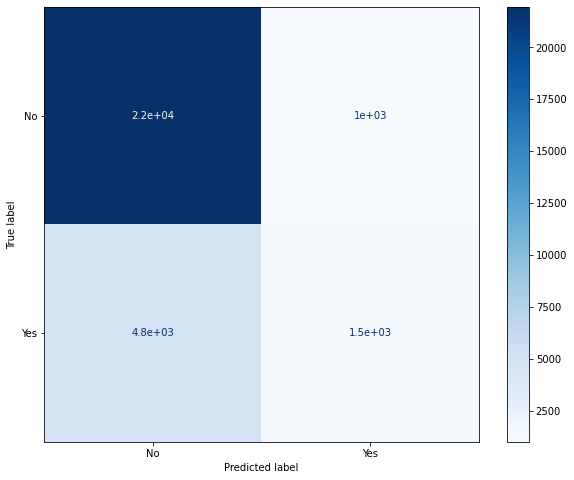

In [152]:
ens_logistic_model = validate_ens_model(ens_logistic_model, X_tr=X_train, X_ts=X_test, y_tr=y_train, y_ts=y_test)

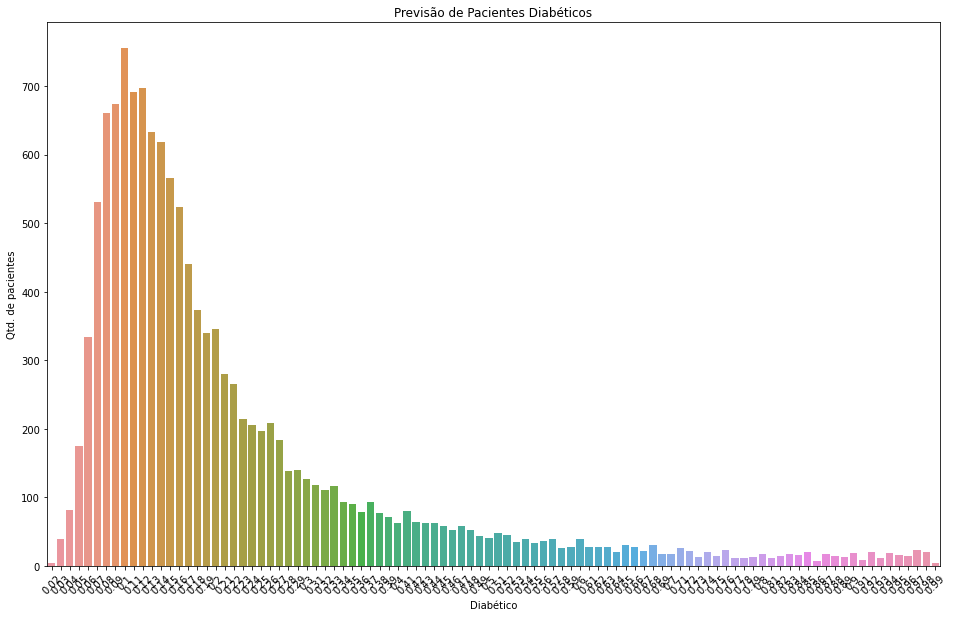

In [153]:
result_logistic_ens = get_dataframe_for_submission(ens_logistic_model)
view_result(result_logistic_ens)

In [123]:
# envia para o kagle o df com o resultado gerado
send_submit(result_logistic_ens, 'Ensemble 2 logistic regression')

100% 339k/339k [00:01<00:00, 273kB/s]
Successfully submitted to Machine Learning Aplicado I - Trabalho Final

#### Decision Tree

In [131]:
ens_tree_model = create_ens_decision_tree(6)

In [132]:
print('****************** ENSEMBLE Árvore de Decisão ******************')
ens_tree_model = create_cross_validation_model(ens_tree_model, 10, work_metric, X_tr=X_train, y_tr=y_train)

****************** ENSEMBLE Árvore de Decisão ******************
Cross Validation Result

roc_auc: [0.8075198  0.81907578 0.80545124 0.81014106 0.79978416 0.81765808
 0.80139097 0.8029049  0.81759959 0.80423737]

roc_auc (média): 0.8086
roc_auc (desvio padrão): 0.0068


Acurácia (Treino): 0.82
Acurácia (Teste): 0.81
              precision    recall  f1-score   support

          NO       0.85      0.92      0.88     32133
         YES       0.59      0.42      0.49      8867

    accuracy                           0.81     41000
   macro avg       0.72      0.67      0.69     41000
weighted avg       0.80      0.81      0.80     41000



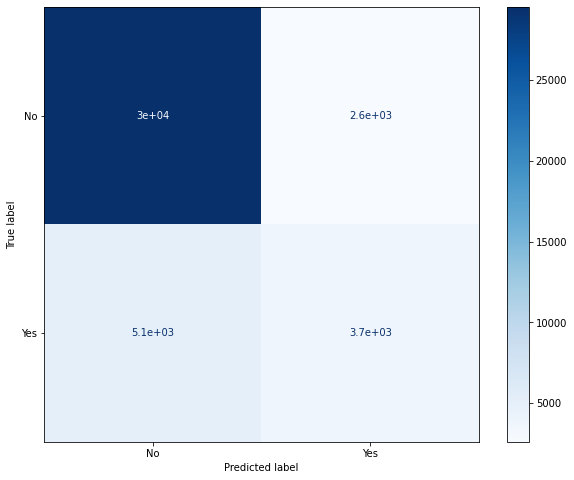

In [133]:
ens_tree_model = validate_ens_model(ens_tree_model, X_tr=X_train, X_ts=X_test, y_tr=y_train, y_ts=y_test)

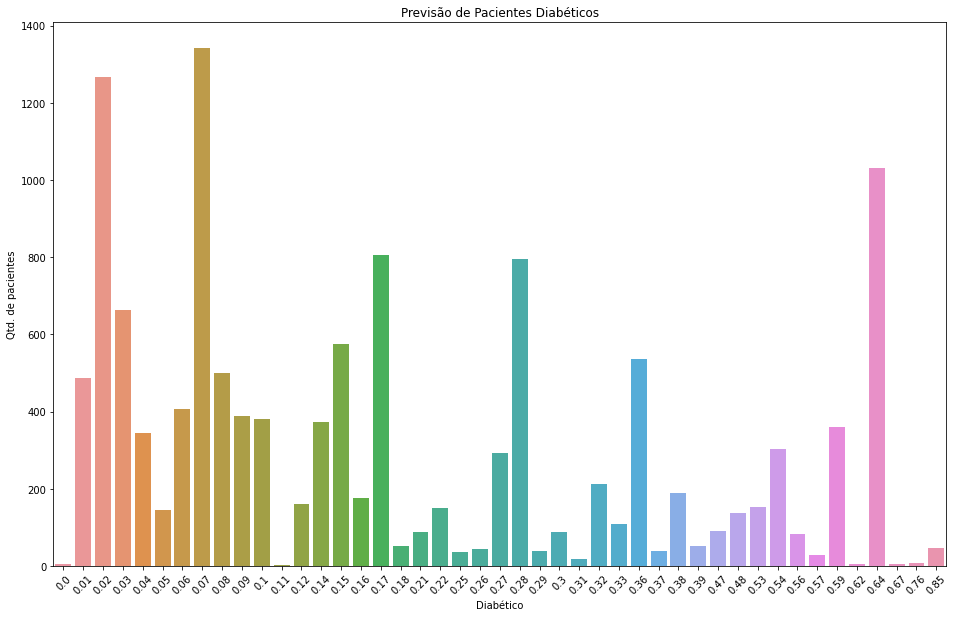

In [134]:
result_tree_ens = get_dataframe_for_submission(ens_tree_model)
view_result(result_tree_ens)

In [98]:
# envia para o kagle o df com o resultado gerado
send_submit(result_tree_ens, 'Ensemble 2 Decision Tree')

100% 340k/340k [00:01<00:00, 311kB/s]
Successfully submitted to Machine Learning Aplicado I - Trabalho Final